
# Cancer Cell Detection: YOLO

This code fine-tunes a YOLOv10 model for the detection of cancer cells in images. 

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv10

In [3]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.5 MB/s eta 0:00:00


We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [4]:
!pip install -q supervision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.1 MB/s eta 0:00:00


## Download pre-trained weights

YOLOv10 provides weight files pre-trained on the [COCO dataset](https://cocodataset.org/) in various sizes. Let's download them.

In [5]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!ls -lh {HOME}/weights

total 11M
-rw-r--r-- 1 root root 11M May 26  2024 yolov10n.pt


## Download dataset from Roboflow Universe

Roboflow is a platform designed to simplify the process of creating, managing, and preprocessing computer vision datasets. 

To fine-tune the YOLO model for cancer cell detection we use [this dataset](https://universe.roboflow.com/national-yang-ming-chiao-tung-university-jvm0d/cell-type-ss5wm).

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

import os
from dotenv import load_dotenv, find_dotenv
_= load_dotenv(find_dotenv())
#ROBOFLOW_API_KEY = os.environ["ROBOFLOW_API_KEY"]
ROBOFLOW_API_KEY = "wZKgeiCJuOw9rVjBBi3h"

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("national-yang-ming-chiao-tung-university-jvm0d").project("cancer-cell-box")
version = project.version(2)
dataset = version.download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cancer-cell-box-2 in yolov8:: 100%|██████████| 3158/3158 [00:00<00:00, 8837.63it/s]


## Fine-tuning YOLO

The follwoing command fine-tunes YOLOv10 on a custom dataset using the Ultralytics YOLO CLI. 

Let's break it down:

```bash
yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml
```

- **`yolo task=detect`** → Specifies the task as **object detection**.
- **`mode=train`** → Runs YOLO in **training mode**.
- **`epochs=10`** → Trains for **10 epochs** (iterations over the dataset).
- **`batch=32`** → Uses a **batch size of 32**, meaning 32 images are processed per training step.
- **`plots=True`** → Enables **visualization** of training metrics (loss, accuracy, etc.).
- **`model={HOME}/weights/yolov10n.pt`** → Uses a **pretrained YOLOv10n model** stored in the `{HOME}/weights/` directory.  
   - **YOLOv10n** is the **nano** version, optimized for speed and efficiency.
- **`data={dataset.location}/data.yaml`** → Specifies the **dataset configuration file**, which includes:
   - Paths to training and validation images.
   - Class labels for the dataset.

In [9]:
%cd {HOME}

!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/content
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New h

YOLO creates several results files, including the fine-tuned model:

In [11]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1741606284.ac8c83ce43d1.2837.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


/content


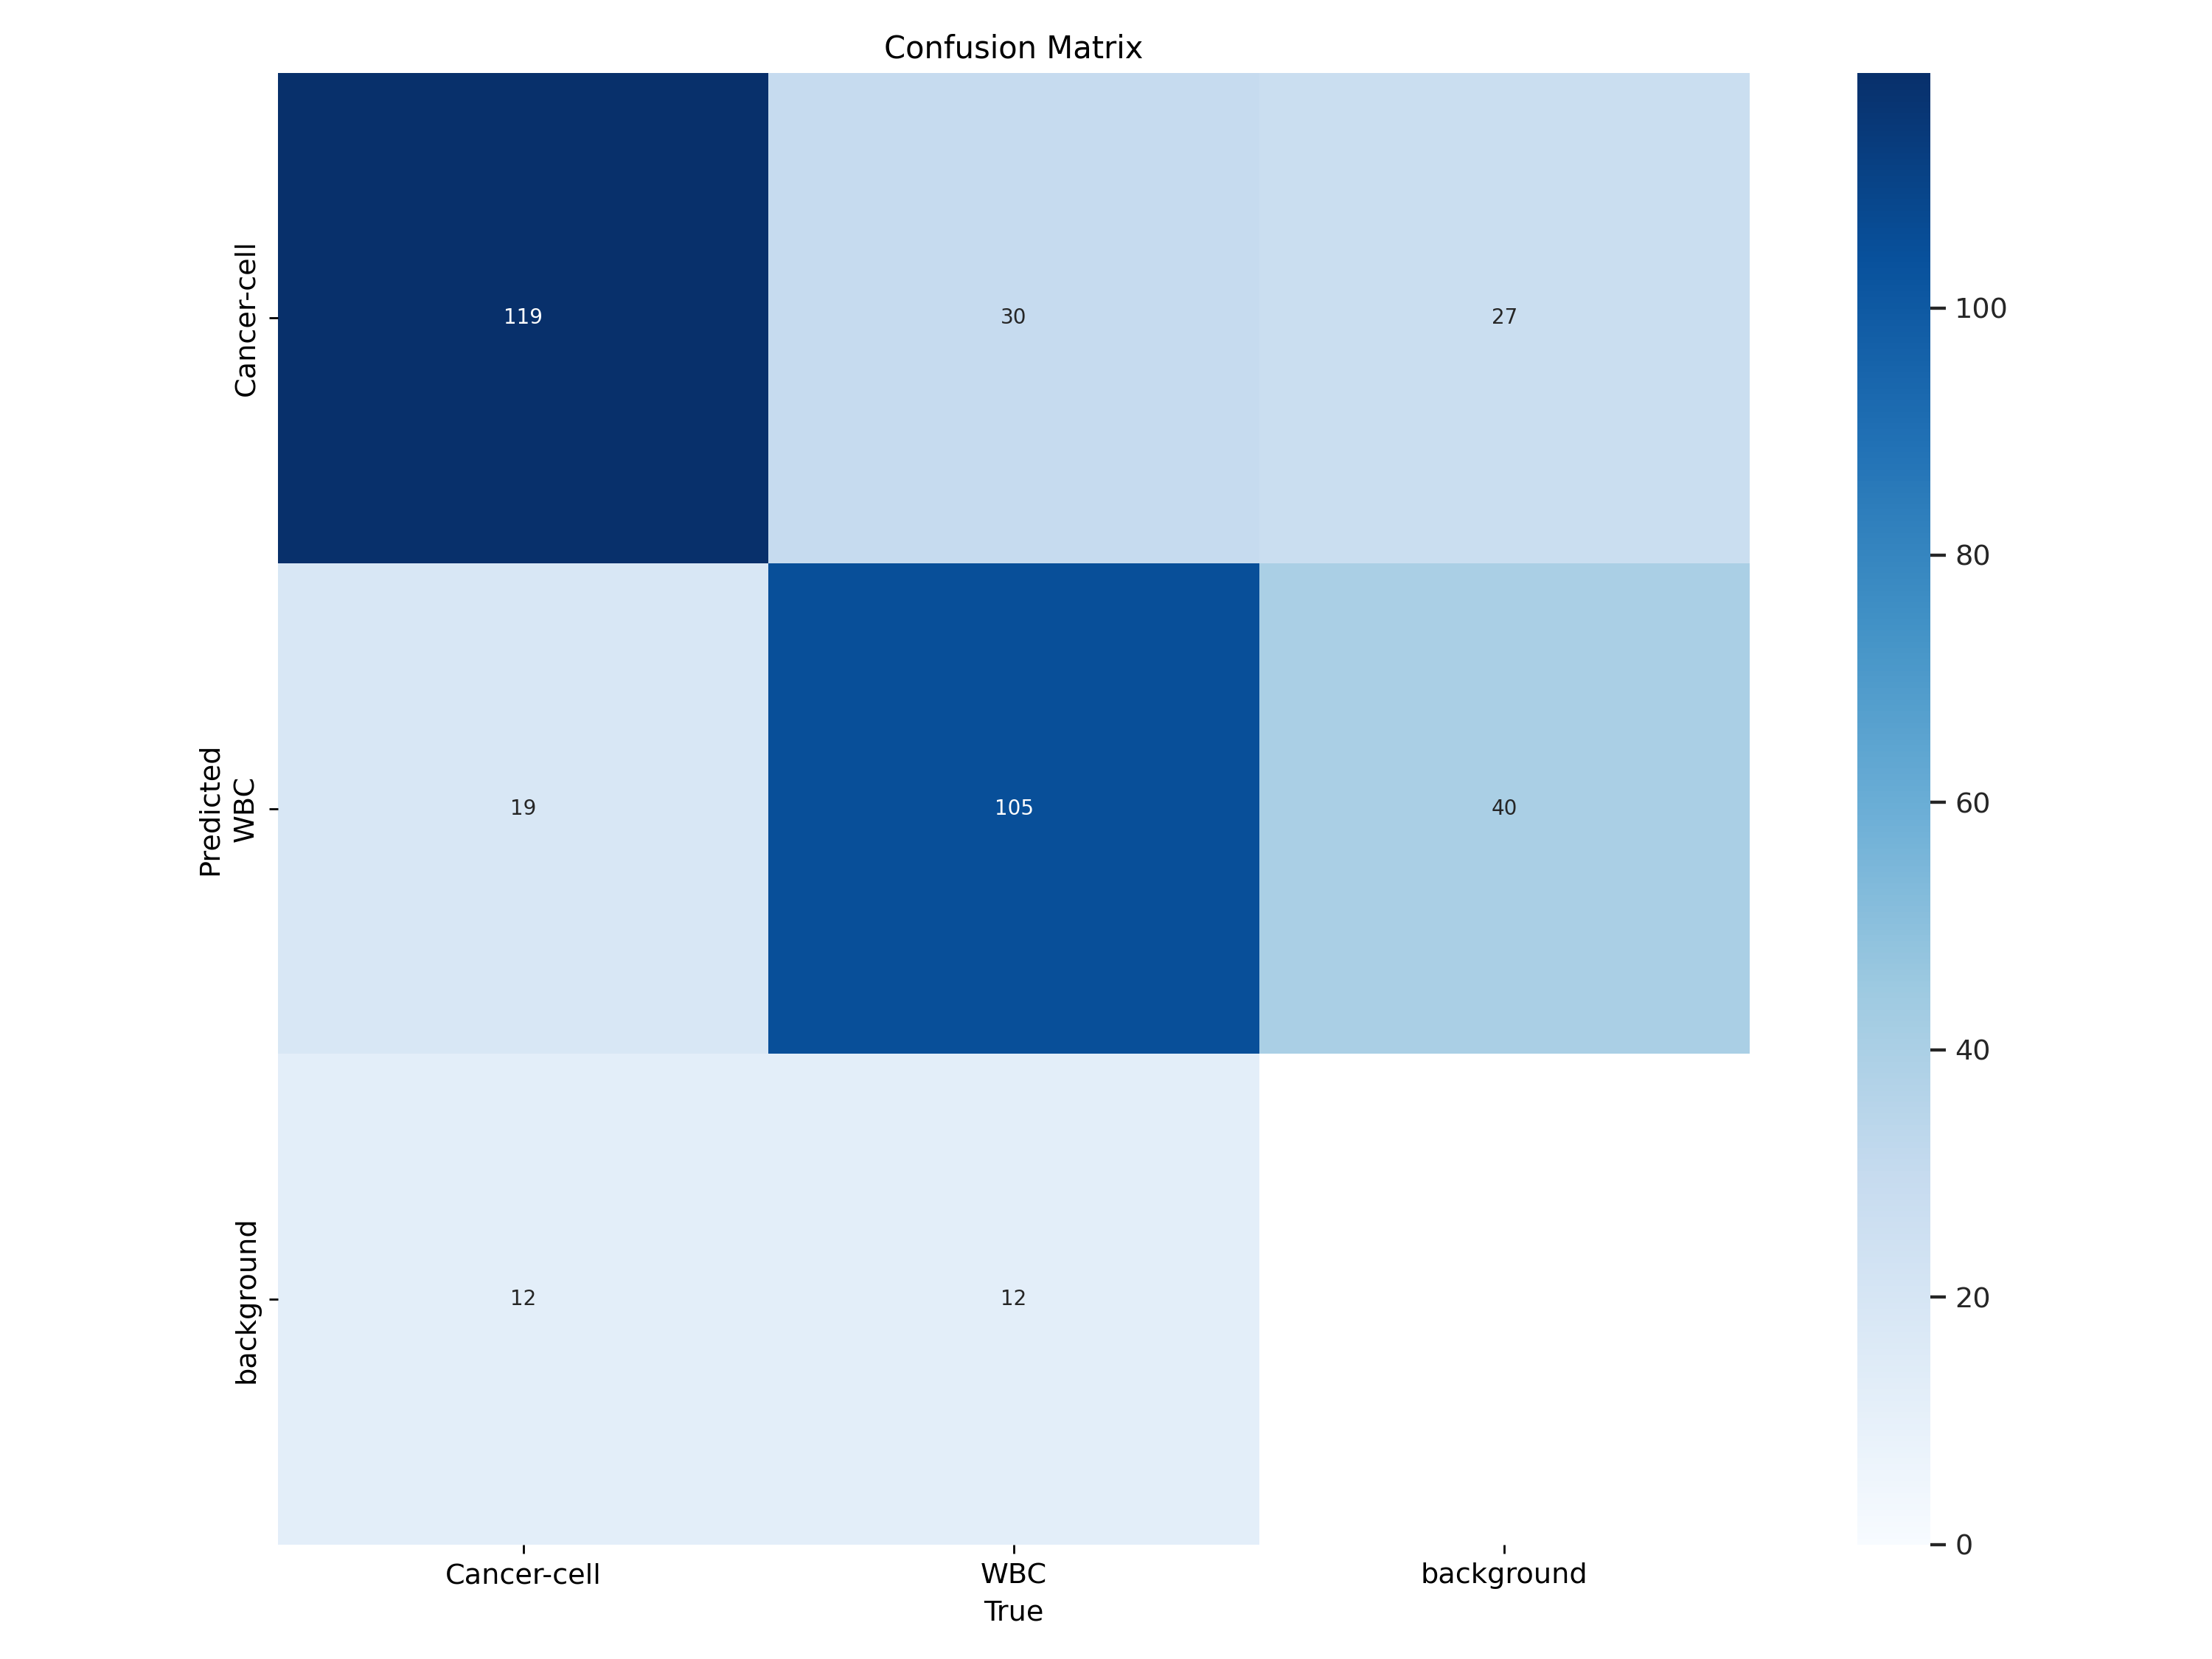

In [13]:
from IPython.display import Image, display
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


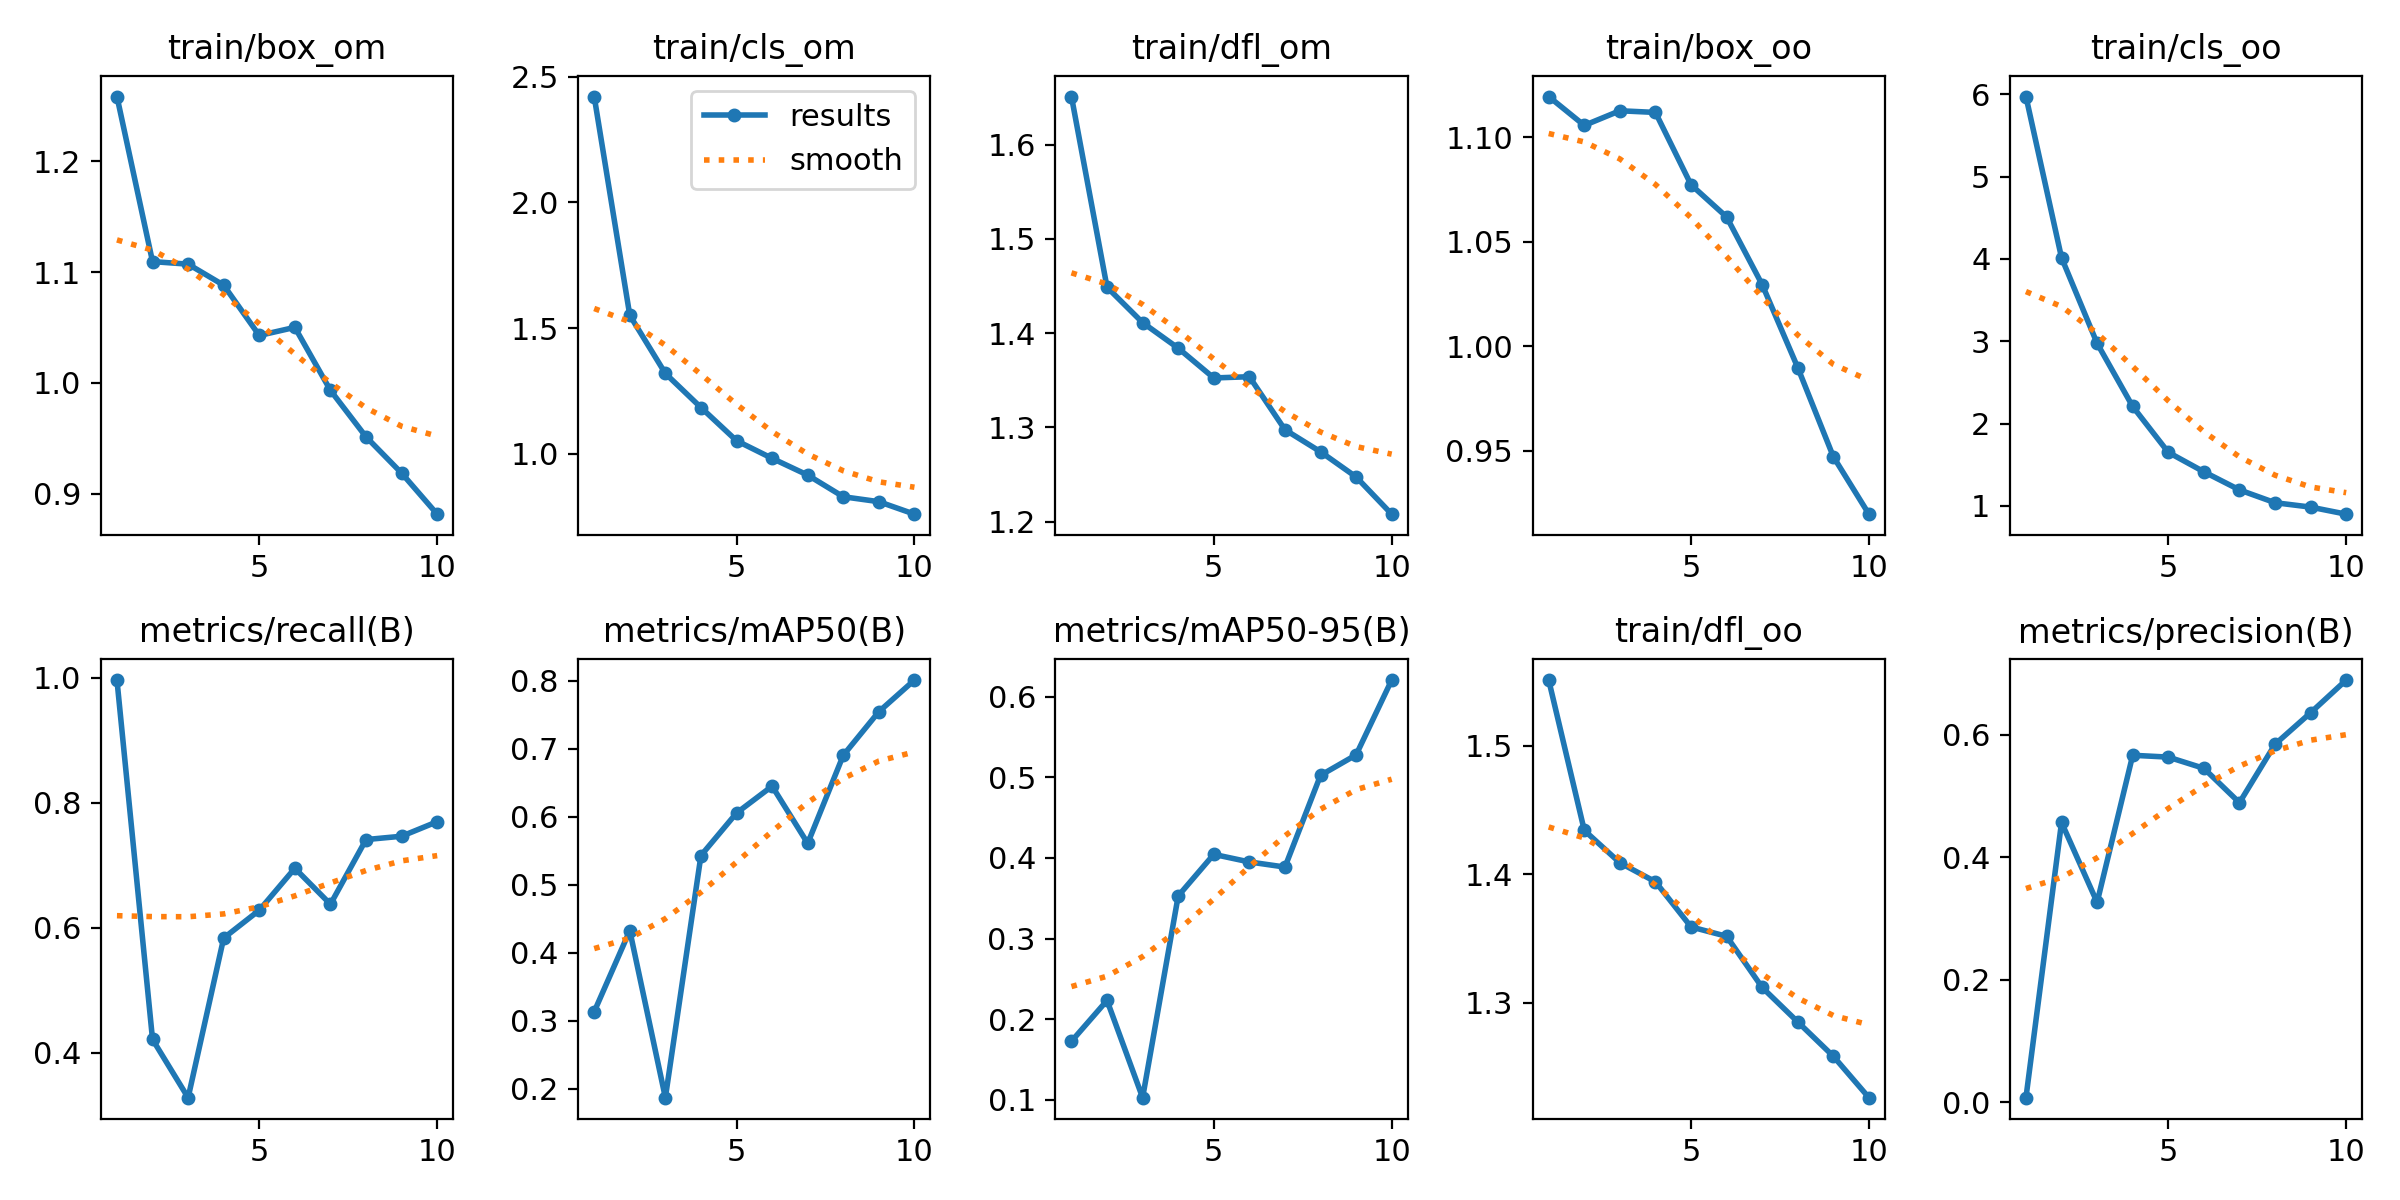

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

Let's start by loading our newly trained model:

In [ ]:
from ultralytics import YOLOv10
import supervision as sv

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Let's randomly select an image from our validation set and visualize the results.

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x640 1 Cancer-cell, 2 WBCs, 27.2ms
Speed: 4.6ms preprocess, 27.2ms inference, 163.6ms postprocess per image at shape (1, 3, 640, 640)


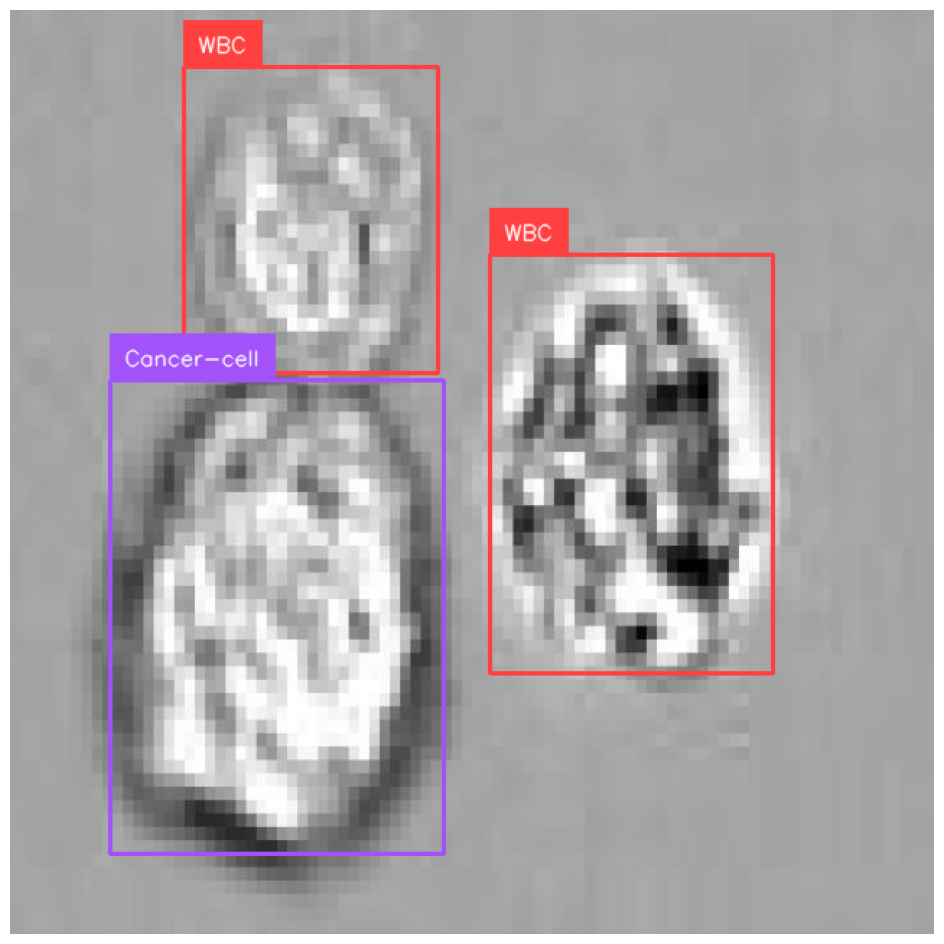

In [16]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)